In [69]:
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm
from functools import partial
from multiprocessing import RawArray, Pool
pmap = p_map

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE


from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff

#rand_indices = np.random.default_rng(2).choice(np.arange(10000), size=10)
rng = np.random.default_rng(2)

def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Load Data

In [2]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000

print("loading data")

all_group_paths = ['../processed/cifar100/clip_new/group2.pkl']
            # '../processed/cifar100/resnets/group2.pkl']

all_groups = list(map(load_pickle, tqdm(all_group_paths)))
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

loading data


  0%|          | 0/1 [00:00<?, ?it/s]

done
loading dataset
Files already downloaded and verified
done


In [5]:
grouped = {k : g[name][k] for g in all_groups for k in g[name].keys()}
groups = list(grouped.keys())
print('groups: ', groups)

## add soft probs
for _, G in grouped.items():
    G['xsoft'] = probs_to_softacc(G["probs"])

groups:  ['ClipViTB32', 'ClipViTB16']


In [6]:
grouped['ClipViTB32']['probs'].shape

(10000, 100, 49)

In [19]:
def std_single(Gi, x, gridpts, t="probs"):
    """
        Return a "standard form" for the stackplots.
        Gi : (NUM_LABELS, NUM_CHECKPOINTS)
        x : the input x-axis (of Gi)
        gridpts : the output x-axis (to standardize wrt)
    """
    xx = gridpts
    res = []
    for j, y in enumerate(Gi):
        # linearly interpolate the curve on uniform grid
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        res.append(yy)
    return np.array(res)

gridpts = 50
t = 'probs'
x = G['xsoft'] if t=='probs' else G['x']
xx = np.linspace(x.min(), x.max(), gridpts) # gridpts

i = rng.choice(np.arange(NUM_SAMPLES))
sample = std_single(G[t][i], xx, t)

In [21]:
sample.shape

(100, 50)

In [23]:
sample.sum(axis=1).shape

(100,)

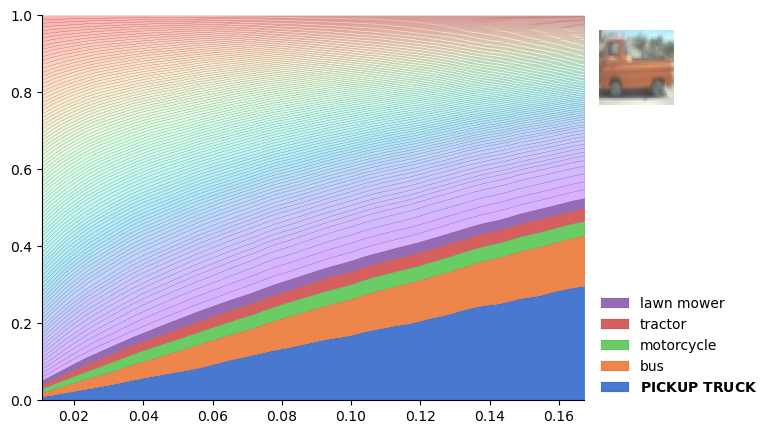

In [379]:
def stacksimple(i, x, prof, topk=5, ax=None):
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals
    #top_labels = ind[:topk]
    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 5))
    
    
    colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    cm = sns.color_palette('rainbow', as_cmap=True)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    # cp = 0.7 # fraction of color space to take up with topk
    # c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # cm = sns.color_palette('husl', as_cmap=True)
    # colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.3))
        s.set_linewidth(0.2)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    # ax.set_axis_off()  
    sns.despine()
    
    ax2 = f.add_axes([0.9, 0.7, 0.15, 0.15], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return ax

    
i = rng.choice(np.arange(NUM_SAMPLES))
sample = std_single(G[t][i], xx, t)

# sns.set_style('white')
sns.reset_defaults()

mpl.rcParams['font.family'] = 'sans-serif'
ax = stacksimple(i, xx, sample)

In [96]:


#%lprun -f std_single std_single(0,  G=grouped[groups[0]])

q = np.array(pmap(lambda i: std_single(G[t][i], gridpts=xx, t=t), range(NUM_SAMPLES)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
q= np.array(q)

In [15]:
q.shape

(10000, 100, 50)

In [74]:
mpl.rcParams['font.family']

['sans-serif']

In [112]:
"$\bf{" +'hi' + '}'

'$\x08f{hi}'

In [325]:
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'cra',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tige